# Imports

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from math import sqrt, pi as PI
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# Data generation

In [2]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

In [3]:
anchors_pos = torch.stack((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_ANCHORS),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_ANCHORS)
), 1)

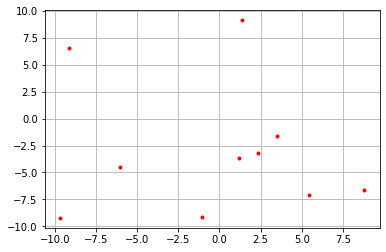

In [4]:
plt.plot(*anchors_pos.T, '.', c='r')
plt.grid()

In [5]:
def generate_random_simulation(min_x, max_x, min_y, max_y, n_steps):
    # generate starting position
    start_x = min_x + (max_x - min_x) * torch.rand(1)
    start_y = min_y + (max_y - min_y) * torch.rand(1)
    
    # generate random directions
    random_angles = torch.rand(N_STEPS) * 2 * PI
    random_dir_xs = torch.cos(random_angles)
    random_dir_ys = torch.sin(random_angles)
    random_dirs = torch.cat((random_dir_xs[..., None], random_dir_ys[..., None]), 1)
    
    # generate resulting positions
    positions = []
    GAMMA = 0.9 # momentum factor
    pos_x = start_x
    pos_y = start_y
    dir_prev_x, dir_prev_y = random_dirs[0]
    for dir_x, dir_y in random_dirs:
        # weighted average between the new and previous direction (to have some smoothness)
        newDir_x = (1 - GAMMA) * dir_x + GAMMA * dir_prev_x
        newDir_y = (1 - GAMMA) * dir_y + GAMMA * dir_prev_y
        dir_prev_x = newDir_x
        dir_prev_y = newDir_y

        # bound the obtained position
        pos_x = torch.clamp(pos_x + newDir_x, min_x, max_x)
        pos_y = torch.clamp(pos_y + newDir_y, min_y, max_y)

        positions.append([pos_x, pos_y])

    positions = torch.FloatTensor(positions)
    
    return positions

In [6]:
def noise(size, std):
    return torch.Tensor(size).normal_(std=std)

RSSI_T = 60
RSSI_N = 2
RSSI_STD = 5
def RSSI(dist, n_samples):
    noise_samples = noise(dist.size() + tuple([n_samples]), RSSI_STD)
    RSSIs = RSSI_T - 10 * RSSI_N * torch.log10(dist).view(dist.size()) + noise_samples.mean(dim=-1)
    return RSSIs, noise_samples.std(dim=-1)

RTT_A = 10
RTT_B = 10
RTT_STD = 4
def RTT(dist):
    return RTT_A * dist + RTT_B + noise(dist.size(), RTT_STD)

In [7]:
class Random_simulation(Dataset):
    
    def __init__(self, n_simulations, n_steps, min_x, min_y, max_x, max_y, anchors_pos):
        self.simulations = torch.stack([generate_random_simulation(min_x, max_x, min_y, max_y, N_STEPS) for i in range(N_SIMULATIONS)])
        self.anchors_pos = anchors_pos
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        
        distances = self.simulations[..., None, :].sub(anchors_pos).pow(2).sum(dim=3).sqrt()
        RSSIs, STDs = RSSI(distances, 10)
        RTTs = RTT(distances)
        
        self.features = torch.cat((
            RSSIs,
            STDs,
            RTTs
        ), -1)
        
    def plot_simulation(self, positions):
        plt.xlim(self.min_x, self.max_x)
        plt.ylim(self.min_y, self.max_y)
        plt.plot(*positions.T)

        for x, y in self.anchors_pos:
            plt.plot(x, y, '.', c='r', markersize=15)

        plt.plot(*positions[0], '*', c='green', markersize=15)
        plt.plot(*positions[-1], '*', c='orange', markersize=15);
        
    def __len__(self):
        return self.simulations.size(0)

    def __getitem__(self, idx):
        return self.features[idx], self.simulations[idx]

In [8]:
data = Random_simulation(N_SIMULATIONS, N_STEPS, MIN_X, MIN_Y, MAX_X, MAX_Y, anchors_pos)

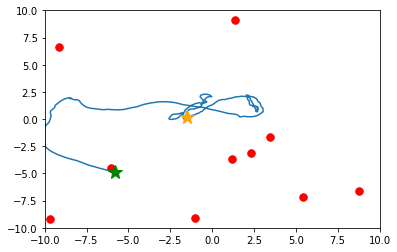

In [9]:
data.plot_simulation(data[0][1])

In [10]:
SPLIT_RATIO = 0.8
BATCH_SIZE = 1

indices = torch.randperm(N_SIMULATIONS)
split = int(SPLIT_RATIO * N_SIMULATIONS)
train_indices = indices[:split]
test_indices = indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(data, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(data, batch_size=BATCH_SIZE, sampler=test_sampler)

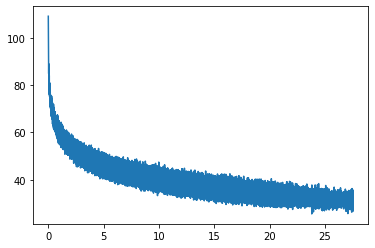

In [11]:
dist = data.simulations[..., None, :].sub(anchors_pos).pow(2).sum(dim=3).sqrt()

values, indices = dist.flatten().sort()
plt.plot(values, data.features.narrow(2, 0, 10).flatten()[indices])

In [12]:
criterion = nn.MSELoss()

def train_encoder(model, train_loader, test_loader, nb_epochs):
    """Train a model"""
    
    optimizer = Adam(model.parameters())
    train_losses = []
    test_losses = []

    for _ in range(nb_epochs):
        losses = []
        for batch_input, _ in train_loader:
            output = model(batch_input.view(-1, batch_input.size(-1)))
            loss = criterion(output, batch_input.view(-1, batch_input.size(-1)))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        for batch_input, _ in test_loader:
            output = model(batch_input.view(-1, batch_input.size(-1)))
            loss = criterion(output, batch_input.view(-1, batch_input.size(-1)))
            losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [13]:
def plot_loss_evolution(train_losses, test_losses):
    plt.plot(train_losses, c='blue')
    plt.plot(test_losses, c='orange')
    plt.legend(['train loss', 'test loss'])
    plt.ylim(0, 200)
    plt.grid();

In [14]:
N_EPOCHS = 500

### ReLU

In [15]:
%%time

dims = [2,3,4,5,6]
n_dims = len(dims)
results_relu = {}

for dim in dims:
    encoder = nn.Sequential(
        nn.Linear(30, 12), nn.ReLU(),
        nn.Linear(12, dim)
    )

    decoder = nn.Sequential(
        nn.Linear(dim, 12), nn.ReLU(),
        nn.Linear(12, 30)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    train_losses, test_losses = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results_relu[dim] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

CPU times: user 7min 42s, sys: 8.83 s, total: 7min 51s
Wall time: 7min 51s


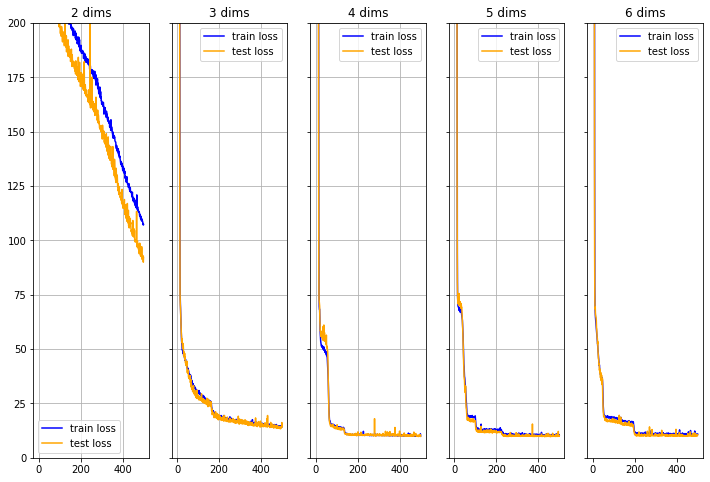

In [16]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(12, 8))
plt.grid()

for i in range(n_dims):
    dim = dims[i]
    
    ax[i % 5].grid()
    ax[i % 5].plot()
    ax[i % 5].plot(results_relu[dim]['train_losses'], c='blue')
    ax[i % 5].plot(results_relu[dim]['test_losses'], c='orange')
    ax[i % 5].legend(['train loss', 'test loss'])
    ax[i % 5].set_title(f'{dim} dims')
    
plt.ylim(0, 200);

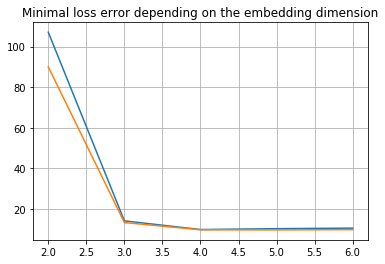

In [17]:
min_losses = {dim: [min(results_relu[dim]['train_losses']), min(results_relu[dim]['test_losses'])] for dim in dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid()
plt.plot(dims, [min_losses[dim][0] for dim in dims])
plt.plot(dims, [min_losses[dim][1] for dim in dims]);

CPU times: user 3min 7s, sys: 3.38 s, total: 3min 10s
Wall time: 3min 11s


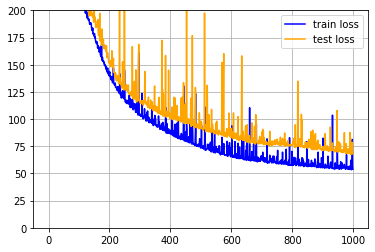

In [15]:
%%time

encoder = nn.Sequential(
    nn.Linear(30, 12), nn.ReLU(),
    nn.Linear(12, 2)
)

decoder = nn.Sequential(
    nn.Linear(2, 12), nn.ReLU(),
    nn.Linear(12, 30)
)

model_relu_2 = nn.Sequential(
    encoder,
    decoder
)

train_losses, test_losses = train_encoder(model_relu_2, train_loader, test_loader, 1000)
plot_loss_evolution(train_losses, test_losses)

In [16]:
encoder, _ = model_relu_2
encoded_data = encoder(data[:][0])

(-10.94019832611084, 9.744164848327637, -10.128678607940675, 10.03472833633423)

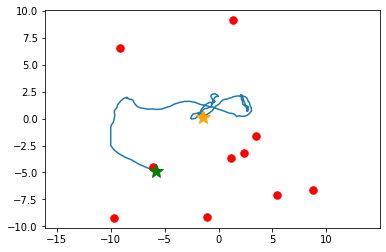

In [26]:
data.plot_simulation(data[0][1])
plt.axis("equal")

(-48.944643592834474, 7.9906831741333, 35.34722843170166, 171.9661298751831)

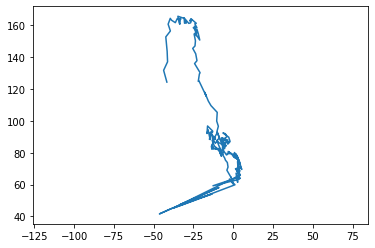

In [30]:
plt.plot(*encoded_data[0].detach().T)
plt.axis("equal")

In [21]:
from scipy.spatial.distance import pdist, squareform

In [33]:
distance_matrix_input = pdist(data[0][0].view(1 * N_STEPS, 30))
distance_matrix_encoded = pdist(encoded_data[0].view(1 * N_STEPS, 2).detach())

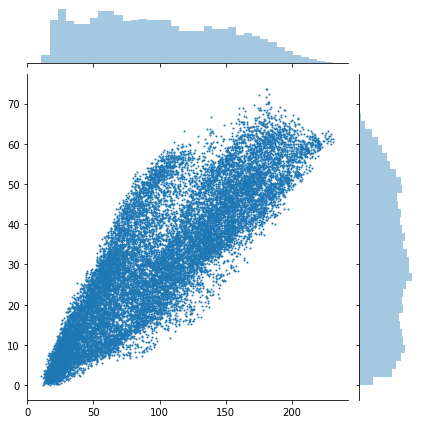

In [50]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, s=1)

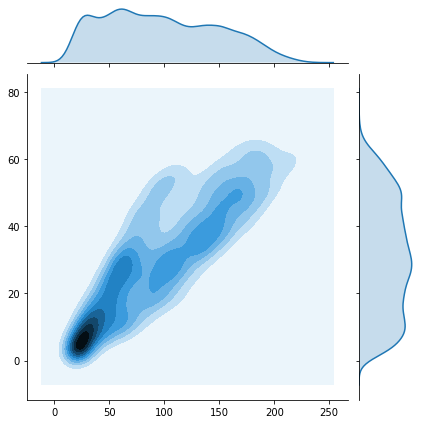

In [44]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, kind='kde')

In [56]:
np.abs(distance_matrix_encoded - distance_matrix_input)

array([17.19454125, 30.85270469, 33.00978255, ..., 23.95492696,
       21.31840386, 21.34376964])

### Tanh

In [19]:
dims = [2,3,4,5,6]
n_dims = len(dims)
results = {}

for dim in dims:
    encoder = nn.Sequential(
        nn.Linear(30, 12), nn.Tanh(),
        nn.Linear(12, dim)
    )

    decoder = nn.Sequential(
        nn.Linear(dim, 12), nn.Tanh(),
        nn.Linear(12, 30)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    train_losses, test_losses = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results[dim] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

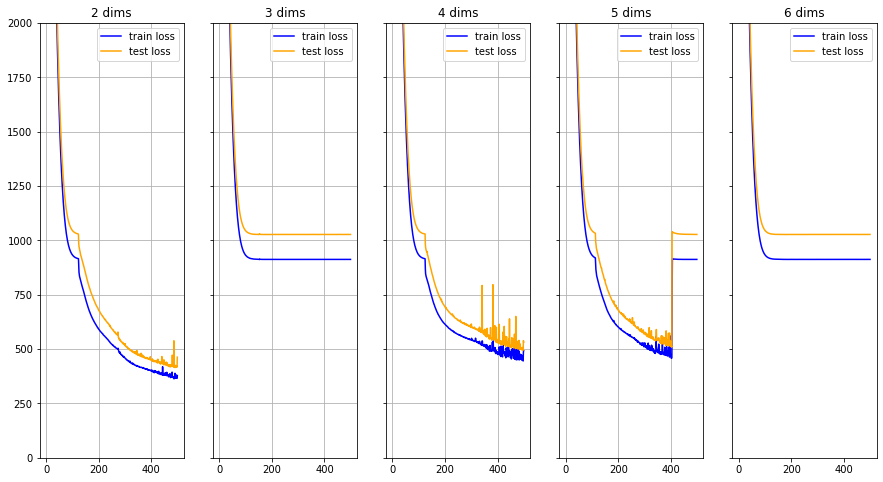

In [22]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 8))
plt.grid()

for i in range(n_dims):
    dim = dims[i]
    
    ax[i % 5].set_title(f'{dim} dims')
    ax[i % 5].plot(results[dim]['train_losses'], c='blue')
    ax[i % 5].plot(results[dim]['test_losses'], c='orange')
    ax[i % 5].grid()
    ax[i % 5].legend(['train loss', 'test loss'])
    
plt.ylim(0, 2000);

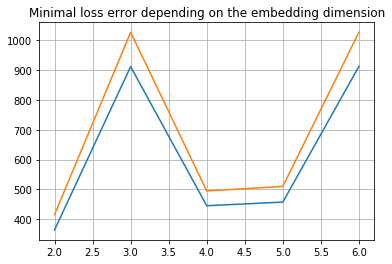

In [21]:
min_losses = {dim: [min(results[dim]['train_losses']), min(results[dim]['test_losses'])] for dim in dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid()
plt.plot(dims, [min_losses[dim][0] for dim in dims])
plt.plot(dims, [min_losses[dim][1] for dim in dims]);

### PCA

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=2)
pca_2D_embedding = pca.fit_transform(data[:][0].view(N_SIMULATIONS * N_STEPS, 30))

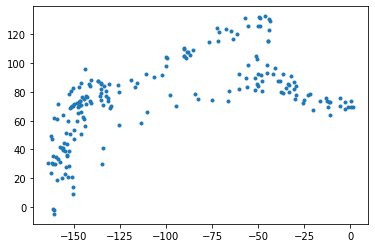

In [53]:
plt.plot(*pca_2D_embedding.reshape((N_SIMULATIONS, N_STEPS, 2))[0].T, '.')

In [54]:
pca_recovery_loss = criterion(data[:][0].view(N_SIMULATIONS * N_STEPS, 30), torch.FloatTensor(pca.inverse_transform(pca_2D_embedding)))
pca_recovery_loss

tensor(149.4587)